In [54]:
from dataclasses import dataclass
import random
from string import ascii_uppercase as ASCII_UPPERCASE
from string import ascii_lowercase as ASCII_LOWERCASE
from string import digits as DIGITS
from string import punctuation as PUNCTUATION
import time
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

"""
Reference ranges:
1 Second is equal to:
1000000000 ns (nanosecond) -> 1e-9 seconds
1000000 us (microsecond) -> 1e-6 seconds
1000 ms (millisecond) -> .001 seconds
1 s (second)
"""


# Assumes the network delay is randomly between 0 and 1/10 of 1 millisecond
NETWORK_DELAY_MINIMUM_SEC = 0
NETWORK_DELAY_MAXIMUM_SEC = .0001  # 1/10 milisecond

NETWORK_DELAY_MU = (NETWORK_DELAY_MAXIMUM_SEC + NETWORK_DELAY_MINIMUM_SEC)/2
NETWORK_DELAY_SIGMA = NETWORK_DELAY_MU - NETWORK_DELAY_MINIMUM_SEC

PLOT_DIMS = (10, 10)


def calculate_mu_and_sigma(delay_min: float, delay_max: float) -> Tuple[float, float]:
  mu = (delay_max - delay_min)/2
  sigma = mu - delay_min
  return mu, sigma


def generate_secret_key(
        length: int=64,
        alpha_upper: bool=True,
        alpha_lower: bool=True,
        numeric: bool=False,
        punctuation: bool=False
) -> str:
    """Generate a random secret key based on the parameters"""
    upper = ASCII_UPPERCASE if alpha_upper else ""
    lower = ASCII_LOWERCASE if alpha_lower else ""
    numeric = DIGITS if numeric else ""
    punctuation = PUNCTUATION if punctuation else ""
    available_characters = upper + lower + numeric + punctuation
    return "".join([random.choice(available_characters) for _ in range(length)])


SECRET_API_KEY = generate_secret_key()


def calculate_api_matches(key: str, api_key: str = SECRET_API_KEY) -> int:
    """Iterate over the key/API_key and calculate the number of matches until the first mismatch."""
    matches = 0
    for l, r in zip(key, api_key):
        if l == r:
            matches += 1
        else:
            break
    return matches


def calculate_api_check_time(key: str, api_key: str = SECRET_API_KEY) -> float:
    """Iterate over the key/API_key and calculate the elapsed time.  Breaks on first mismatch."""
    start = time.time()
    for l, r in zip(key, api_key):
        if l == r:
            continue
        else:
            break
    end = time.time()
    elapsed = end - start
    return elapsed


def simulate_network_delay(mu=NETWORK_DELAY_MU, sigma=NETWORK_DELAY_SIGMA, minimum=NETWORK_DELAY_MINIMUM_SEC) -> float:
    """Simulate the network delay for calling the API matching function."""
    return max(random.gauss(mu=mu, sigma=sigma),minimum)


@dataclass
class APIResponse:
    key: str
    matches: int
    func_time: int
    network_delay: int


def simulate_api_check_over_network(key: str, mu: float, sigma: float) -> APIResponse:
    """Simulate a key call to the key-check API"""
    func_time = calculate_api_check_time(key)
    matches = calculate_api_matches(key)
    network_delay = simulate_network_delay(mu=mu, sigma=sigma)
    return APIResponse(key=key, matches=matches, func_time=func_time, network_delay=network_delay)


def run_simulation(
    tries_per_letter: int=100_000,
    min_delay: float=NETWORK_DELAY_MINIMUM_SEC,
    max_delay: float=NETWORK_DELAY_MAXIMUM_SEC
    ) -> pd.DataFrame:

    columns = ["matches", "func_time", "network_delay", "total_elapsed"]
    width = len(columns)
    tries_per_letter = 100_000
    length = len(SECRET_API_KEY) * tries_per_letter

    arr = np.zeros((length, width), dtype=np.float64)
    mu, sigma = calculate_mu_and_sigma(min_delay, max_delay)
    for i in range(1, len(SECRET_API_KEY) + 1):
        k = SECRET_API_KEY[:i]
        for j in range(tries_per_letter):
            row = tries_per_letter * (i-1) + j
            response = simulate_api_check_over_network(k, mu, sigma)
            arr[row][0] = response.matches
            arr[row][1] = response.func_time
            arr[row][2] = response.network_delay
            arr[row][3] = arr[row][1] + arr[row][2]

    df = pd.DataFrame(arr, columns=columns)
    return df

Slope: 1.920482019583384e-08, Intercept: 1.385202755530676e-07


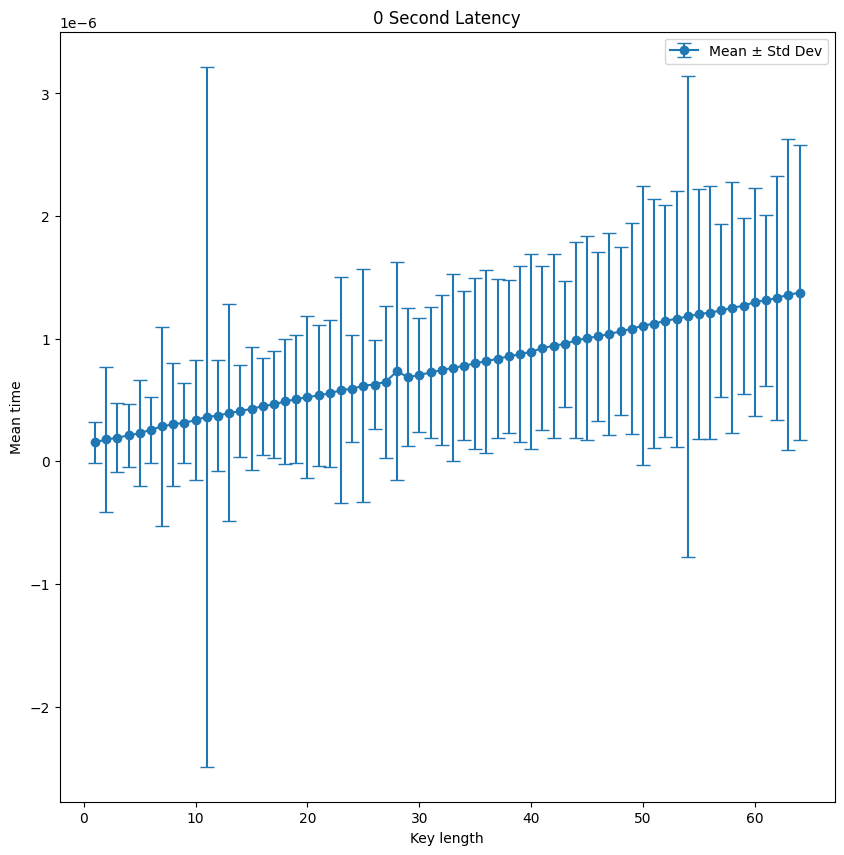

In [55]:
zero_latency = run_simulation(min_delay=0, max_delay=0)
zero_latency_total_elapsed_summary = zero_latency.groupby('matches').agg(['mean', 'std'])['total_elapsed']

x = zero_latency_total_elapsed_summary.index.values
y = zero_latency_total_elapsed_summary['mean'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")


x = zero_latency_total_elapsed_summary.index.values
y = zero_latency_total_elapsed_summary['mean'].values
yerr = zero_latency_total_elapsed_summary['std'].values

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean time')
plt.legend()
plt.title("0 Second Latency")
plt.show()

Slope: 1.9175096526011436e-08, Intercept: 5.569660850356217e-06


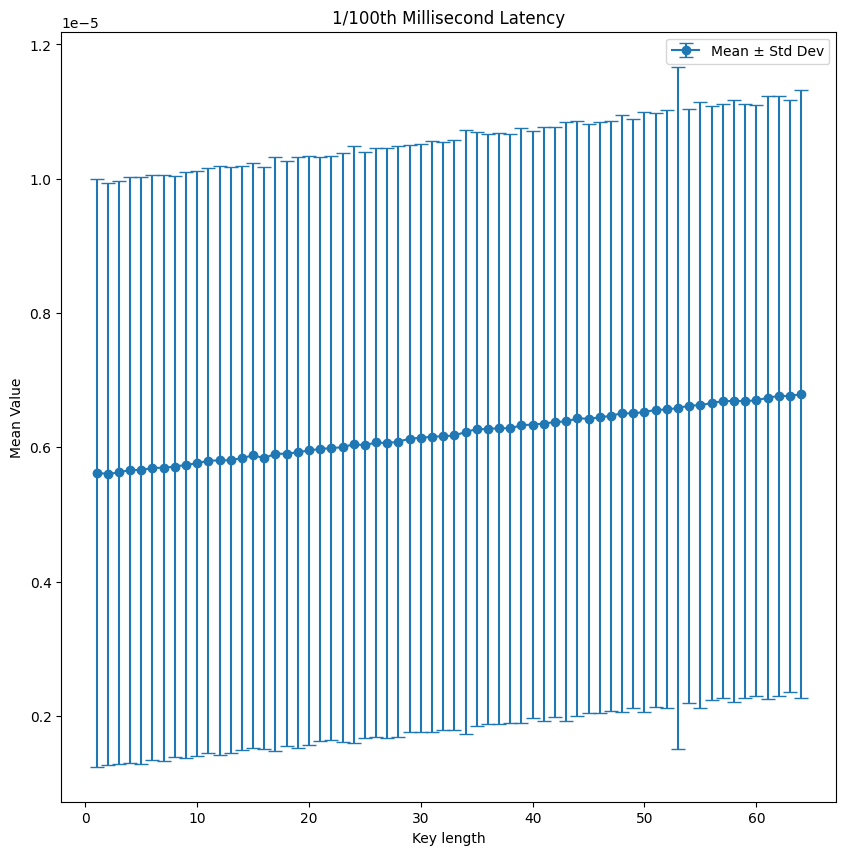

In [56]:
one_hundredth_millisecond = run_simulation(min_delay=0, max_delay=0.00001)
one_hundredth_millisecond_total_elapsed_summary = one_hundredth_millisecond.groupby('matches').agg(['mean', 'std'])['total_elapsed']

x = one_hundredth_millisecond_total_elapsed_summary.index.values
y = one_hundredth_millisecond_total_elapsed_summary['mean'].values
yerr = one_hundredth_millisecond_total_elapsed_summary['std'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean Value')
plt.legend()
plt.title("1/100th Millisecond Latency")
plt.show()


Slope: 1.8474043025338423e-08, Intercept: 5.434052224528496e-05


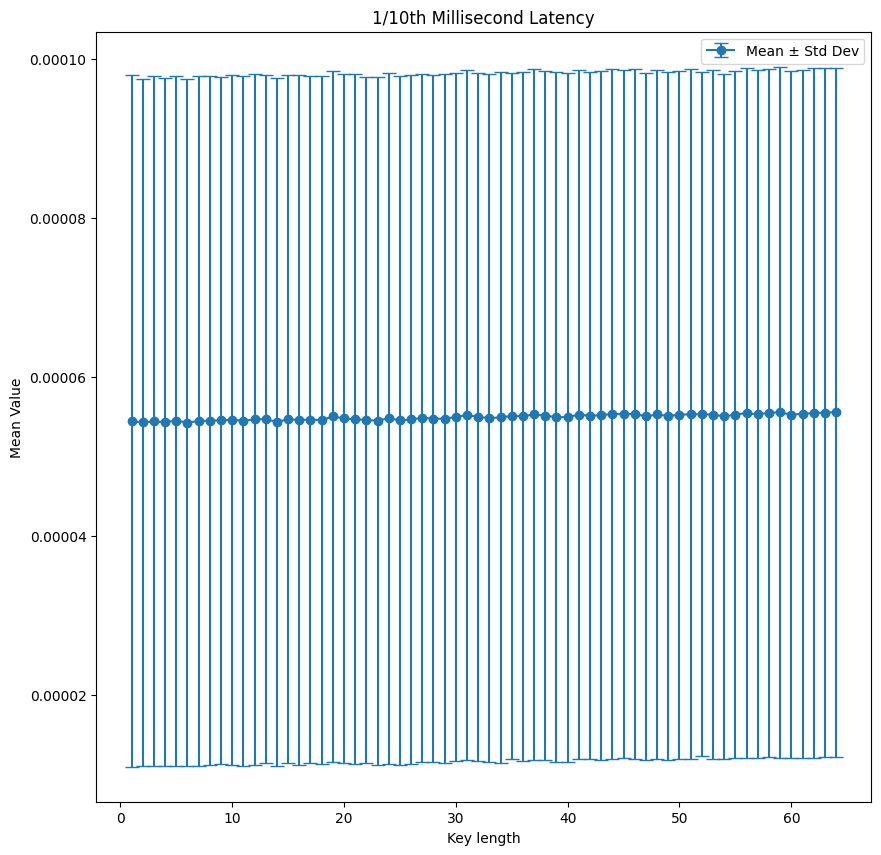

In [57]:
one_tenth_millisecond = run_simulation(min_delay=0, max_delay=0.0001)
one_tenth_millisecond_total_elapsed_summary = one_tenth_millisecond.groupby('matches').agg(['mean', 'std'])['total_elapsed']

x = one_tenth_millisecond_total_elapsed_summary.index.values
y = one_tenth_millisecond_total_elapsed_summary['mean'].values
yerr = one_tenth_millisecond_total_elapsed_summary['std'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean Value')
plt.legend()
plt.title("1/10th Millisecond Latency")
plt.show()


Slope: 2.318646616643764e-08, Intercept: 0.0005416152287553876


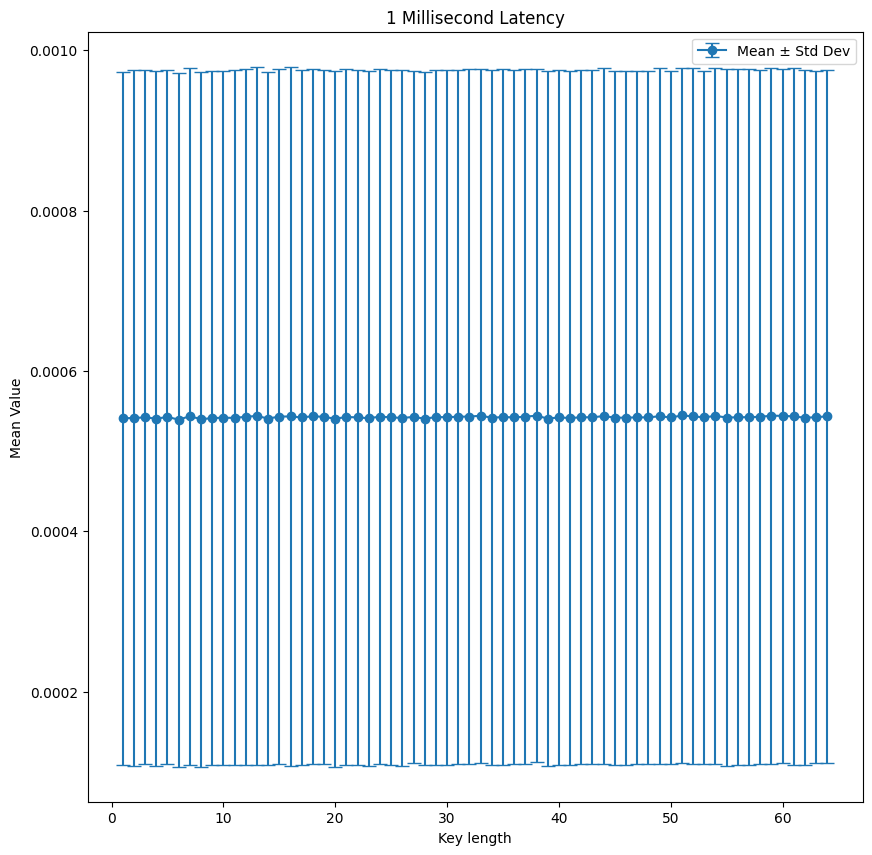

In [58]:
one_millisecond = run_simulation(min_delay=0, max_delay=0.001)
one_millisecond_latency_total_elapsed_summary = one_millisecond.groupby('matches').agg(['mean', 'std'])['total_elapsed']

x = one_millisecond_latency_total_elapsed_summary.index.values
y = one_millisecond_latency_total_elapsed_summary['mean'].values
yerr = one_millisecond_latency_total_elapsed_summary['std'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean Value')
plt.legend()
plt.title("1 Millisecond Latency")
plt.show()


Slope: 1.5483373696131745e-08, Intercept: 0.0010835675924494366


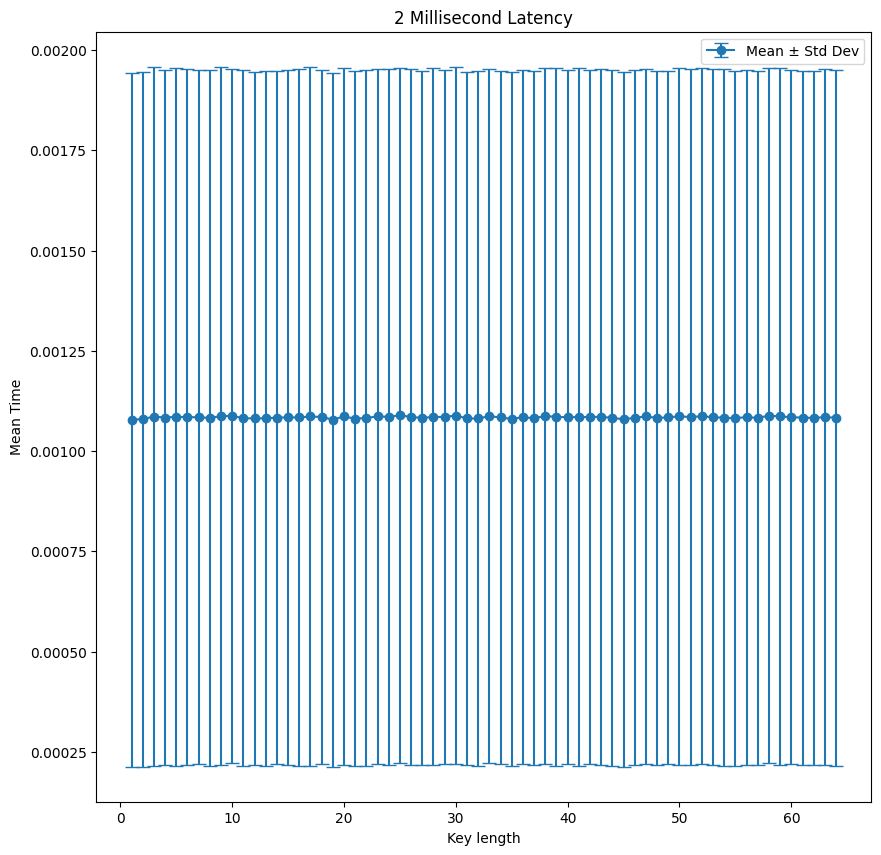

In [59]:
two_millisecond = run_simulation(min_delay=0, max_delay=0.002)
two_millisecond_latency_total_elapsed_summary = two_millisecond.groupby('matches').agg(['mean', 'std'])['total_elapsed']

x = two_millisecond_latency_total_elapsed_summary.index.values
y = two_millisecond_latency_total_elapsed_summary['mean'].values
yerr = two_millisecond_latency_total_elapsed_summary['std'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean Time')
plt.legend()
plt.title("2 Millisecond Latency")
plt.show()


Slope: 1.7187821250855978e-08, Intercept: 0.0027079838112943574


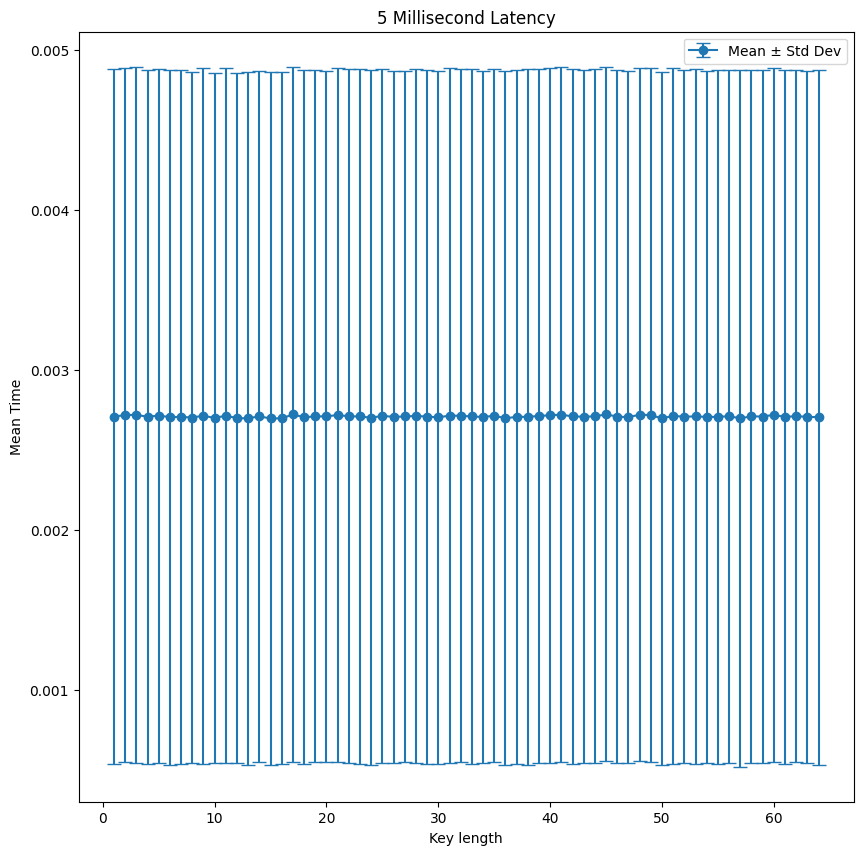

In [60]:
five_millisecond = run_simulation(min_delay=0, max_delay=0.005)
five_millisecond_latency_total_elapsed_summary = five_millisecond.groupby('matches').agg(['mean', 'std'])['total_elapsed']

x = five_millisecond_latency_total_elapsed_summary.index.values
y = five_millisecond_latency_total_elapsed_summary['mean'].values
yerr = five_millisecond_latency_total_elapsed_summary['std'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean Time')
plt.legend()
plt.title("5 Millisecond Latency")
plt.show()


Slope: -1.0667227903446174e-07, Intercept: 0.005417098180845503


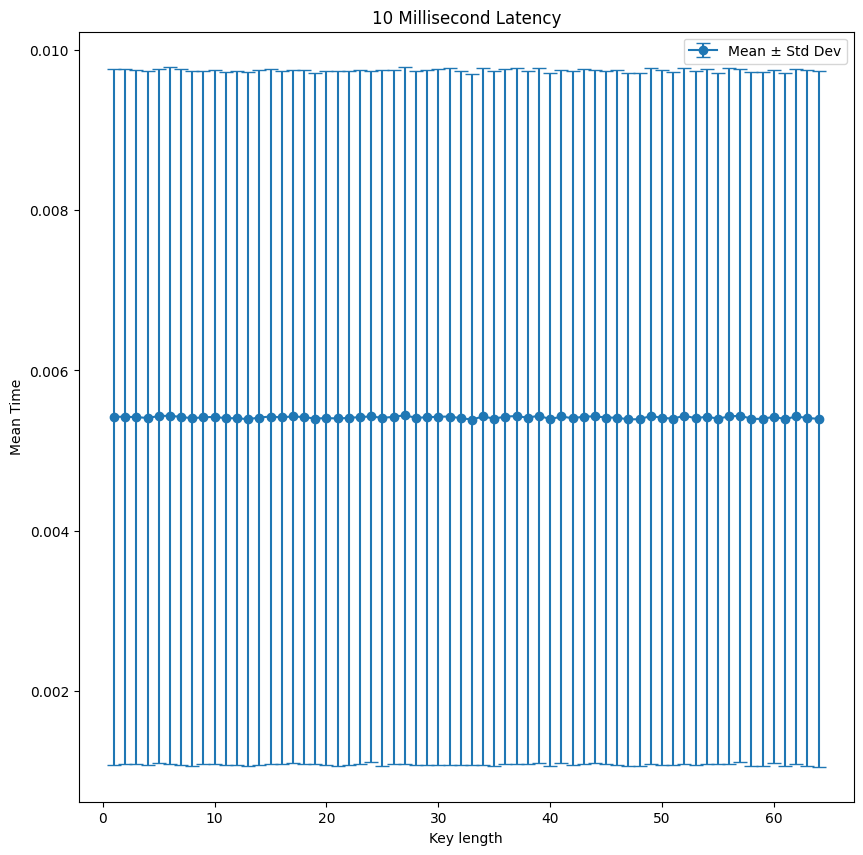

In [61]:

ten_millisecond = run_simulation(min_delay=0, max_delay=0.01)
ten_millisecond_latency_total_elapsed_summary = ten_millisecond.groupby('matches').agg(['mean', 'std'])[
    'total_elapsed']

x = ten_millisecond_latency_total_elapsed_summary.index.values
y = ten_millisecond_latency_total_elapsed_summary['mean'].values
yerr = ten_millisecond_latency_total_elapsed_summary['std'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}")

plt.figure(figsize=PLOT_DIMS)
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('Key length')
plt.ylabel('Mean Time')
plt.legend()
plt.title("10 Millisecond Latency")
plt.show()
